In [98]:
%reload_ext autoreload
%autoreload 2  

# Load data

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

file_name = "IrishNationalTideGaugeNetwork_8eaa_cdad_02f5.csv"
df = pd.read_csv(file_name)
df.drop(columns=['latitude', 'longitude', 'Water_Level_OD_Malin'], inplace=True)
df = df.iloc[1:]
df['Water_Level_LAT'] = df['Water_Level_LAT'].astype(float)
mean_every_12_rows = df.groupby(df.index // 12)['Water_Level_LAT'].mean()

mean_every_12_rows

0      3.091273
1      2.602500
2      2.193083
3      2.006667
4      2.120333
         ...   
163    1.263250
164    1.791250
165    2.539833
166    3.213000
167    3.627400
Name: Water_Level_LAT, Length: 168, dtype: float64

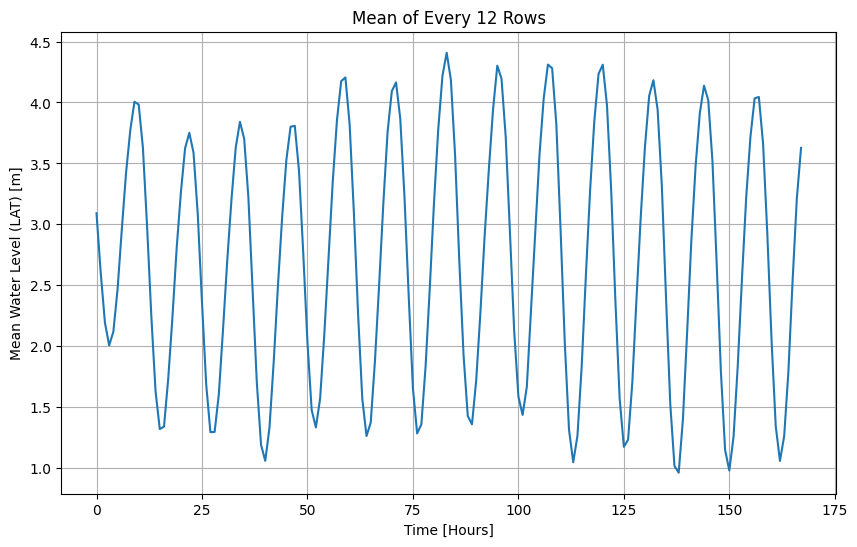

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(mean_every_12_rows.index, mean_every_12_rows.values)
plt.title('Mean of Every 12 Rows')
plt.xlabel('Time [Hours]')
plt.ylabel('Mean Water Level (LAT) [m]')
plt.grid(True)
plt.show()

# Expectation matrix

### Format data

In [101]:
import numpy as np
data = np.array(mean_every_12_rows)
print(data.shape)
print(data[0])

# Rescale the data to be between 0 and 2np.pi
data = (data - data.min())/(data.max() - data.min()) * 2 * np.pi
data[150]

# get training data
train_x = data[:-30]
print(train_x.shape)

# get test data
test_x = data[-30:]
print(test_x.shape)

(168,)
3.091272727272727
(138,)
(30,)


In [102]:
m = 8

n = (m-1)*5

train_matrix = np.tile(train_x, (n, 1)).transpose()
print("train_matrix.shape: ", train_matrix.shape)
train_matrix[:2] 

# prediction matrix
test_matrix = np.tile(test_x, (n, 1)).transpose()
print("test_matrix.shape: ", test_matrix.shape)

train_matrix.shape:  (138, 35)
test_matrix.shape:  (30, 35)


### Generate circuit object

In [103]:
import perceval as pcvl
import lo_reservoir as lrs

t_max_train = train_x.shape[0]

simulator = lrs.PhotonicReservoirSimulator(m, t_max_train, overlapping=True)

# generate the layers
_ = simulator.set_circuit_with_stored_layers()

Generating layers: 100%|██████████| 138/138 [00:00<00:00, 314.86it/s]


In [104]:
# input_state = pcvl.BasicState([3]*(m-2) + [0]*2)
input_state = pcvl.BasicState([1]*m)
train_expectation_matrix = simulator.sequential_expectation_calculation(train_matrix, input_state)
print("expectations_matrix.shape = ", np.array(train_expectation_matrix).shape)

Processing time steps: 100%|██████████| 138/138 [00:11<00:00, 12.23it/s]

expectations_matrix.shape =  (138, 8)


In [105]:
import perceval as pcvl
import lo_reservoir as lrs

t_max_test = test_x.shape[0]

simulator = lrs.PhotonicReservoirSimulator(m, t_max_test, overlapping=True)

# generate the layers
_ = simulator.set_circuit_with_stored_layers()

Generating layers: 100%|██████████| 30/30 [00:00<00:00, 397.29it/s]


In [106]:

test_expectation_matrix = simulator.sequential_expectation_calculation(test_matrix, input_state)
print("expectations_matrix.shape = ", np.array(test_expectation_matrix).shape)

Processing time steps: 100%|██████████| 30/30 [00:01<00:00, 19.26it/s]

expectations_matrix.shape =  (30, 8)


# Linear Regression

In [107]:
from sklearn.linear_model import LinearRegression

# pop the last row of expectations_matrix
expectations_matrix_red = np.array(train_expectation_matrix)[:-1]
print("expectations_matrix.shape = ", expectations_matrix_red.shape)

# make prediction vector
labels = np.array(train_x)[1:]
data_red = np.array(train_x)[1:]
print("labels:", labels[:3])
print("data_red: ", data_red[:4])
print("labels shape: ", labels.shape)


# fit the model
reg = LinearRegression().fit(expectations_matrix_red, labels)

labels

expectations_matrix.shape =  (137, 8)
labels: [2.99056039 2.24405987 1.9041613 ]
data_red:  [2.99056039 2.24405987 1.9041613  2.11141282]
labels shape:  (137,)


array([2.99056039, 2.24405987, 1.9041613 , 2.11141282, 2.75140065,
       3.64118429, 4.48356142, 5.12020648, 5.54975197, 5.50796739,
       4.86129403, 3.66899003, 2.33401068, 1.21281643, 0.653055  ,
       0.68982543, 1.40791244, 2.32747709, 3.35856858, 4.19274075,
       4.85552016, 5.08525938, 4.78486623, 3.86818852, 2.55144244,
       1.32100051, 0.60640822, 0.61081459, 1.17832516, 2.15517267,
       3.18489667, 4.09412914, 4.86402902, 5.24981465, 4.99804356,
       4.11904794, 2.74380345, 1.34971791, 0.41769386, 0.17762245,
       0.6755427 , 1.6564927 , 2.78862691, 3.82138979, 4.67744188,
       5.17566602, 5.18949291, 4.51562159, 3.29171325, 1.95065615,
       0.93810181, 0.67751797, 1.10691151, 2.07129963, 3.21452574,
       4.3579038 , 5.27716456, 5.85819814, 5.91320184, 5.2098534 ,
       3.89964091, 2.37701081, 1.10599985, 0.54912536, 0.75075495,
       1.67062349, 2.82266235, 4.04170848, 5.10258099, 5.70807754,
       5.83920515, 5.29479006, 4.12710097, 2.64488795, 1.26417

In [108]:
predicted_data = reg.predict(test_expectation_matrix)
print("predicted_data.shape = ", predicted_data.shape)\

# rescale the prediction data 
print(predicted_data)
print(test_x)

predicted_data.shape =  (30,)
[3.15643311 3.15643311 2.28143311 3.84393311 2.96893311 2.59393311
 4.03143311 4.34393311 3.21893311 3.65643311 3.40643311 3.15643311
 3.65643311 3.03143311 3.15643311 3.09393311 3.71893311 3.09393311
 3.15643311 3.09393311 2.59393311 2.53143311 3.46893311 3.15643311
 2.84393311 2.78143311 3.34393311 2.90643311 3.71893311 3.15643311]
[0.         0.79998478 2.10503118 3.47647707 4.58202109 5.37729561
 5.79027921 5.57497466 4.66012027 3.13126047 1.51366541 0.33822718
 0.03281989 0.539249   1.60543954 2.90851067 4.12056738 5.02205071
 5.6014129  5.62162145 4.92055216 3.58071061 1.99411211 0.69635902
 0.17655884 0.54866952 1.51138625 2.87629856 4.10370161 4.85928837]


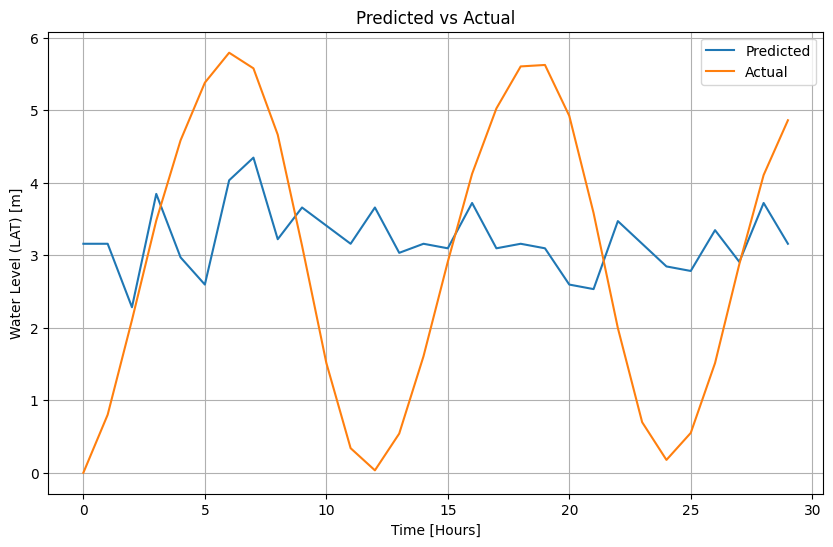

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predicted_data, label='Predicted')
plt.plot(test_x, label='Actual')
plt.title('Predicted vs Actual')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.grid(True)


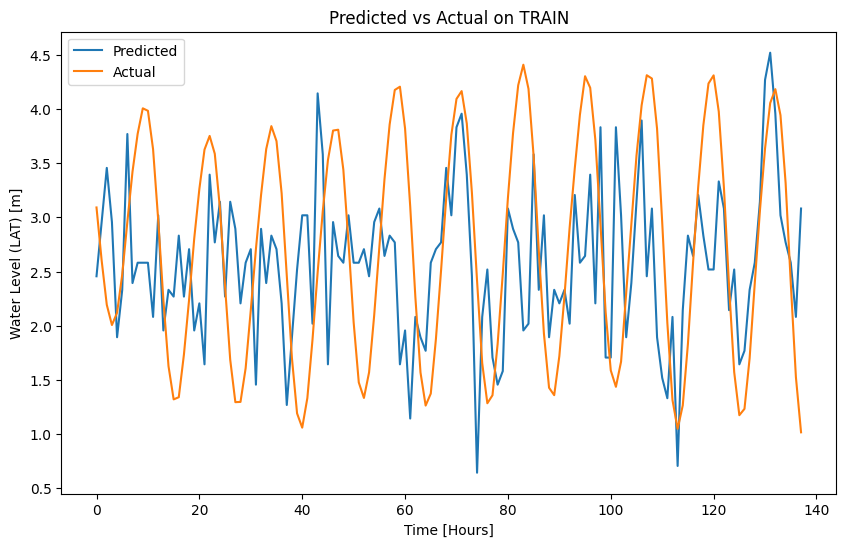

In [112]:
predicted_train_data = reg.predict(train_expectation_matrix) - 0.7

other_data = mean_every_12_rows[:-30]

plt.figure(figsize=(10, 6))
plt.plot(predicted_train_data, label='Predicted')
plt.plot(other_data, label='Actual')
plt.title('Predicted vs Actual on TRAIN')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()

